In [1]:
import pandas as pd
import csv
import datetime
import pickle
import os
import numpy as np
import sys
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import string
from string import punctuation
from langdetect import detect
from scipy.sparse import hstack
from scipy import sparse
from xgboost import XGBClassifier

In [3]:
df = pd.read_pickle('modeling_df_final.pkl')

In [4]:
drop_cols = ['user_id','is_bot','screen_name','text','hashtags','links','timestamp','is_quote_tweet','date_joined']

In [5]:
comparison = df[df['following'] < 12000] #df[(df['followers'] < 12000) & (df['following'] < 12000)]
print(comparison.shape)
print(comparison['is_bot'].value_counts())

y = comparison['is_bot']
X = comparison.drop(drop_cols, axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X.values ,y , test_size = .33, random_state = 42)

(1561014, 18)
1    917493
0    643521
Name: is_bot, dtype: int64


In [6]:
X.head()

,retweets,followers,following,is_retweet,text_cleaned,upper_count,char_count,word_count,hashtag_count
0,0,747.0,180.0,False,a blast from our dazl past make sure you are ...,4,713,89,0
1,3,747.0,180.0,False,a blast from our dazl past make sure you are ...,4,713,89,0
2,1,747.0,180.0,False,a blast from our dazl past make sure you are ...,4,713,89,0
3,1,747.0,180.0,False,a blast from our dazl past make sure you are ...,4,713,89,0
4,1,747.0,180.0,False,a blast from our dazl past make sure you are ...,4,713,89,0


# Modeling with No Text

In [7]:
df.columns

Index(['user_id', 'screen_name', 'timestamp', 'text', 'hashtags', 'retweets',
       'links', 'date_joined', 'followers', 'following', 'is_retweet',
       'is_quote_tweet', 'is_bot', 'text_cleaned', 'upper_count', 'char_count',
       'word_count', 'hashtag_count'],
      dtype='object')

In [8]:
modeling_df = df.groupby(['user_id','is_bot']).agg({'timestamp':['min'],
                                                    'followers':'mean',
                                                    'following':'mean',
                                                    'is_retweet':'sum',
                                                    'is_quote_tweet':'sum',
                                                    'upper_count':'sum', 
                                                    'char_count':'sum',
                                                    'word_count':'sum', 
                                                    'hashtag_count':'sum',
                                                    'screen_name':'count'}).reset_index()


In [9]:
modeling_df.columns = modeling_df.columns.droplevel(1)

In [10]:
modeling_df['posts_during_period'] = modeling_df['screen_name']
modeling_df.drop('screen_name', axis = 1, inplace = True)
modeling_df['ratio_old'] = modeling_df['followers']/(modeling_df['following']+0.0000001)
modeling_df['ratio'] = modeling_df['ratio_old'].fillna(0)
modeling_df.drop(['ratio_old'], axis = 1, inplace = True)
modeling_df['ratio'] = round(modeling_df['ratio'],2)
modeling_df['average_char'] = modeling_df['char_count']/modeling_df['posts_during_period']
#modeling_df['average_upper_char'] = modeling_df['upper_count']/modeling_df['posts_during_period']

In [12]:
modeling_df.shape

(76035, 14)

In [13]:
modeling_df = modeling_df[modeling_df['followers']<12000]
modeling_df.shape

(48867, 14)

In [14]:
modeling_df['is_bot'].value_counts()

0    48184
1      683
Name: is_bot, dtype: int64

In [15]:
y = modeling_df['is_bot']
X = modeling_df.drop(['is_bot','user_id','timestamp', 'is_quote_tweet'], axis = 1)

In [16]:
features = X.columns

## No Text RF Model

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size = 0.2, random_state = 42)

rf_model = RandomForestClassifier(n_estimators=5,random_state = 42) #class_weight={0:1,1:100}
rf_model.fit(X_train, y_train)
accuracy_score(y_test,rf_model.predict(X_test))
precision_score(y_test,rf_model.predict(X_test))
f1_score(y_test,rf_model.predict(X_test))

0.7560975609756098

In [18]:
precision_score(y_test,rf_model.predict(X_test))

0.8378378378378378

In [19]:
rf_model.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=1608637542, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=1273642419, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                        max_features='auto', max_leaf_nodes=None,
                 

In [20]:
accuracy_score(y_test,rf_model.predict(X_test))

0.9938612645794966

In [21]:
recall_score(y_test,rf_model.predict(X_test))

0.6888888888888889

In [22]:
# need to balance for classes

In [23]:
X.columns

Index(['followers', 'following', 'is_retweet', 'upper_count', 'char_count',
       'word_count', 'hashtag_count', 'posts_during_period', 'ratio',
       'average_char'],
      dtype='object')

In [24]:
rf_model.feature_importances_

array([0.24379721, 0.14419947, 0.00261345, 0.06451202, 0.06004035,
       0.13631326, 0.0410959 , 0.11986232, 0.18756602, 0.        ])

In [25]:
y_test.sum()

135

In [26]:
rf_model.predict(X_test).sum()

111

## Logistic Model

In [27]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
f1_score(y_test,log_model.predict(X_test))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.3815028901734104

In [28]:
recall_score(y_test,log_model.predict(X_test))

0.24444444444444444

In [29]:
accuracy_score(y_test,log_model.predict(X_test))

0.9890525885001024

In [30]:
precision_score(y_test,log_model.predict(X_test))

0.868421052631579

## XGB Model No Text

In [32]:
xgb_model = XGBClassifier(max_depth = 3, learning_rate = 0.01, n_estimators = 1000, random_state=38)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=38,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [33]:
pred = xgb_model.predict(X_test)

In [34]:
print(f1_score(y_test, pred))
print(recall_score(y_test, pred))
print(accuracy_score(y_test, pred))

0.8034188034188035
0.6962962962962963
0.9952936361776141


In [35]:
print(precision_score(y_test, xgb_model.predict(X_test)))

0.9494949494949495


In [36]:
feats = {} 
for feature, importance in zip(features, xgb_model.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance',ascending = False)

In [37]:
importances.head(15)

,Gini-importance
upper_count,0.378406
ratio,0.272855
followers,0.177807
following,0.066068
hashtag_count,0.056975
is_retweet,0.047889
char_count,0.000000
word_count,0.000000
posts_during_period,0.000000
average_char,0.000000


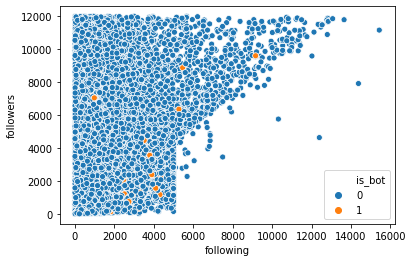

In [39]:
sns.scatterplot(x = 'following', y = 'followers', hue = 'is_bot', data = modeling_df);

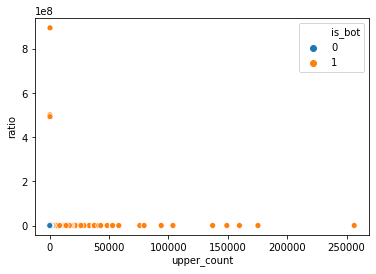

In [40]:
sns.scatterplot(x = 'upper_count', y = 'ratio', hue = 'is_bot', data = modeling_df);

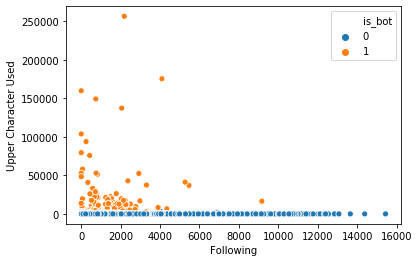

In [41]:
ax = sns.scatterplot(x = 'following', y = 'upper_count', hue = 'is_bot', data = modeling_df)
ax.set_ylabel('Upper Character Used')
ax.set_xlabel('Following');

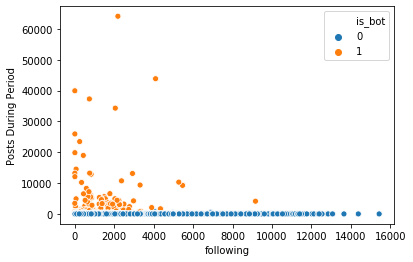

In [43]:
ax = sns.scatterplot(x = 'following', y = 'posts_during_period', hue = 'is_bot', data = modeling_df)
ax.set_ylabel('Posts During Period');

In [45]:
print(xgb_model.predict(X_test).sum())
print(y_test.sum())

99
135


In [46]:
results = pd.DataFrame(X_test)
results.columns = features
results.shape

(9774, 10)

In [47]:
preds = pd.DataFrame(y_test-xgb_model.predict(X_test))
preds.reset_index(inplace=True)

In [48]:
preds.columns = ['index', 'predicted']

In [49]:
results.reset_index(inplace=True)
results
results = pd.concat([results, preds], axis =1)

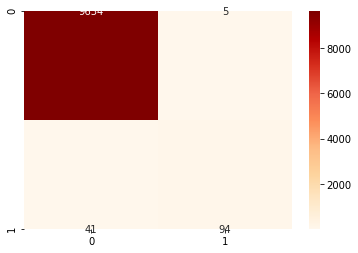

In [52]:
import matplotlib.transforms

conf_matrix = confusion_matrix(y_test, pred)
ax = sns.heatmap(conf_matrix, cmap="OrRd", annot=True, fmt='g')